In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
from tqdm.auto import tqdm
tqdm.pandas()
warnings.filterwarnings('ignore')

In [17]:
print('Importing data...')
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')

Importing data...


# <a id=1 > 1. Processing test and train dataset </a>

In [18]:
target = train['TARGET']
del train['TARGET']

In [19]:
data = pd.concat([train,test])

In [20]:
data.shape, train.shape, test.shape

((356255, 121), (307511, 121), (48744, 121))

In [21]:
docs = [col for col in data.columns if 'FLAG_DOC' in col]
# Flag_document features - count and kurtosis
data['DOCUMENT_COUNT'] = data[docs].sum(axis=1)
data['NEW_DOC_KURT'] = data[docs].kurtosis(axis=1)  #long tails

In [22]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [23]:
# Categorical age - based on target=1 plot
data['AGE_RANGE'] = data['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

In [24]:
# New features based on External sources
data['EXT_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['EXT_SOURCES_WEIGHTED'] = data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 1 + data.EXT_SOURCE_3 * 3
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        data[feature_name] = eval('np.{}'.format(function_name))(
            data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [25]:
# Credit ratios
data['CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']

In [26]:
# Income ratios
data['ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['INCOME_TO_EMPLOYED_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_EMPLOYED']
data['INCOME_TO_BIRTH_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_BIRTH']
data['INCOME_TO_CREDIT_RATION'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']

In [27]:
# Time ratios
data['EMPLOYED_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['ID_TO_BIRTH_RATIO'] = data['DAYS_ID_PUBLISH'] / data['DAYS_BIRTH']
data['CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['CAR_TO_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
data['PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

In [28]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [29]:
# Groupby: Statistics for applications in the same group
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
data = do_median(data, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
data = do_std(data, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
data = do_mean(data, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
data = do_std(data, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
data = do_mean(data, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
data = do_std(data, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
data = do_mean(data, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
data = do_mean(data, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
data = do_std(data, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

In [30]:
# one-hot encoding
categorical_features = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns=categorical_features)

In [31]:
data.shape

(356255, 277)

In [32]:
#Pre-processing previous_application
print('Pre-processing previous_application...')
prev = pd.read_csv('previous_application.csv')
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['COUNT_PREV_APP'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

Pre-processing previous_application...


In [33]:
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

In [34]:
data.shape

(356255, 440)

In [35]:
train = data.iloc[:train.shape[0],:]
test = data.iloc[train.shape[0]:,]

In [36]:
data.shape, train.shape, test.shape

((356255, 440), (307511, 440), (48744, 440))

In [37]:
del train['SK_ID_CURR']
del test['SK_ID_CURR']

In [38]:
train_x, valid_x, train_y, valid_y = train_test_split(train, target, test_size=0.2, shuffle=True)

In [39]:
#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

In [40]:
#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

In [41]:
#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 40 rounds.
[10]	valid_0's auc: 0.735072
[20]	valid_0's auc: 0.740617
[30]	valid_0's auc: 0.74639
[40]	valid_0's auc: 0.750655
[50]	valid_0's auc: 0.754686
[60]	valid_0's auc: 0.758223
[70]	valid_0's auc: 0.760991
[80]	valid_0's auc: 0.763214
[90]	valid_0's auc: 0.76471
[100]	valid_0's auc: 0.766117
[110]	valid_0's auc: 0.767401
[120]	valid_0's auc: 0.768371
[130]	valid_0's auc: 0.769219
[140]	valid_0's auc: 0.769775
[150]	valid_0's auc: 0.770285
[160]	valid_0's auc: 0.770682
[170]	valid_0's auc: 0.771068
[180]	valid_0's auc: 0.771306
[190]	valid_0's auc: 0.771827
[200]	valid_0's auc: 0.771845
[210]	valid_0's auc: 0.772009
[220]	valid_0's auc: 0.772111
[230]	valid_0's auc: 0.772171
[240]	valid_0's auc: 0.772519
[250]	valid_0's auc: 0.772607
[260]	valid_0's auc: 0.772689
[270]	valid_0's auc: 0.773043
[280]	valid_0's auc: 0.772962
[290]	valid_0's auc: 0.773133
[300]	valid_0's auc: 0.773282
[310]	valid_0's auc: 0.773341
[320]	valid_0's auc

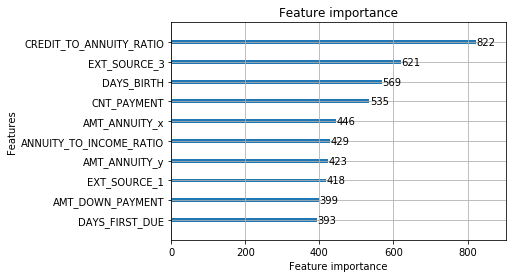

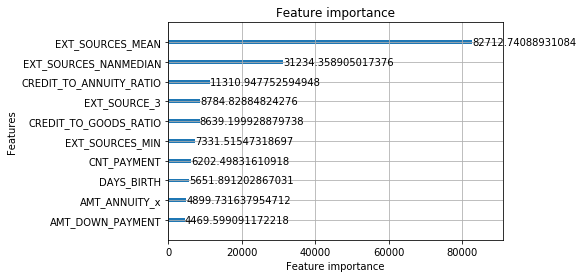

In [42]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=10, importance_type='split')
lgb.plot_importance(lgbm, max_num_features=10, importance_type='gain')

In [43]:
predictions_lgbm_prob = lgbm.predict(test)

In [44]:
lgbm_submission = pd.read_csv('sample_submission.csv')

In [45]:
lgbm_submission.TARGET = predictions_lgbm_prob

In [46]:
lgbm_submission.to_csv('lgbm_submission.csv', index=False) #score : 0.774029

data columns

In [47]:
column_info = pd.read_csv('HomeCredit_columns_description.csv', encoding = 'unicode_escape')

In [62]:
column_info[column_info['Table'] == 'previous_application.csv']

,Unnamed: 0,Table,Row,Description,Special
173,176,previous_application.csv,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
174,177,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed
175,178,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN
177,180,previous_application.csv,AMT_APPLICATION,For how much credit did client ask on the prev...,NaN
178,181,previous_application.csv,AMT_CREDIT,Final credit amount on the previous applicatio...,NaN
179,182,previous_application.csv,AMT_DOWN_PAYMENT,Down payment on the previous application,NaN
180,183,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,NaN
181,184,previous_application.csv,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...,NaN
182,185,previous_application.csv,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...,rounded


In [135]:
import pandas as pd
import numpy as np

In [136]:
payments_file = 'installments_payments.csv'
previous_file = 'previous_application.csv'
df_payments = pd.read_csv(payments_file)
df_previous = pd.read_csv(previous_file)

In [137]:
(df_previous.shape, df_payments.shape)

((1670214, 37), (13605401, 8))

In [138]:
df_previous_filtered = df_previous[['SK_ID_CURR','SK_ID_PREV','AMT_ANNUITY','AMT_CREDIT','CNT_PAYMENT']][df_previous['SK_ID_CURR'] == 100042]

In [139]:
df_previous_filtered.shape

(9, 5)

In [140]:
df_previous_filtered[['AMT_ANNUITY','AMT_CREDIT','CNT_PAYMENT']]

,AMT_ANNUITY,AMT_CREDIT,CNT_PAYMENT
71629,10602.450,95431.5,10.0
369486,39981.060,978408.0,36.0
381415,20150.550,315000.0,24.0
759421,13431.600,119925.0,12.0
1011745,18619.245,247275.0,18.0
1011746,47660.850,1051789.5,36.0
1239501,19148.985,247275.0,18.0
1410163,38934.180,978408.0,36.0
1555449,4500.000,90000.0,0.0


In [141]:
del df_previous
gc.collect()

282

In [142]:
df_previous_filtered['AMT_ANNUITY'] = df_previous_filtered['AMT_ANNUITY'].fillna(0)
df_previous_filtered['AMT_CREDIT'] = df_previous_filtered['AMT_CREDIT'].fillna(0)
df_previous_filtered['CNT_PAYMENT'] = df_previous_filtered['CNT_PAYMENT'].fillna(0)

In [143]:
def get_ear(annuity, credit, no_of_payments):
    """ derives ear and returns
    """
    PMT = [-credit]
    PMT = PMT + ([annuity] * int(no_of_payments))
    irr = np.irr(PMT)
    
    return (1+irr)**12 - 1

In [144]:
df_previous_filtered['EXPECTED_EAR'] = df_previous_filtered.progress_apply(lambda x: get_ear(x.AMT_ANNUITY, x.AMT_CREDIT, x.CNT_PAYMENT), axis=1)

In [145]:
df_previous_filtered

,SK_ID_CURR,SK_ID_PREV,AMT_ANNUITY,AMT_CREDIT,CNT_PAYMENT,EXPECTED_EAR
71629,100042,1125423,10602.450,95431.5,10.0,0.262451
369486,100042,1127680,39981.060,978408.0,36.0,0.306959
381415,100042,1716930,20150.550,315000.0,24.0,0.556842
759421,100042,1643964,13431.600,119925.0,12.0,0.769366
1011745,100042,1643959,18619.245,247275.0,18.0,0.496636
1011746,100042,2535181,47660.850,1051789.5,36.0,0.413872
1239501,100042,2639682,19148.985,247275.0,18.0,0.556684
1410163,100042,2604725,38934.180,978408.0,36.0,0.281528
1555449,100042,2137382,4500.000,90000.0,0.0,NaN


In [146]:
#df_previous_payments = df_previous.merge(df_payments, on='SK_ID_CURR', how='inner')

In [147]:
#df_previous_payments.shape

In [148]:
#df_previous_10 = df_previous[df_previous['SK_ID_PREV'] == 2604725]

In [171]:
df_payments_filtered = df_payments[['SK_ID_PREV','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT','AMT_INSTALMENT']][df_payments['SK_ID_PREV'].isin(df_previous_filtered['SK_ID_PREV'].tolist())]
#df_payments_filtered = df_payments[['SK_ID_PREV','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT','AMT_INSTALMENT']][df_payments['SK_ID_PREV'].isin(['1125423'])]

In [172]:
df_payments_filtered.shape

(182, 4)

In [173]:
df_previous_payments = df_payments_filtered.merge(df_previous_filtered[['SK_ID_CURR','SK_ID_PREV','EXPECTED_EAR','AMT_CREDIT']], on='SK_ID_PREV', how='inner')

In [175]:
df_previous_payments

,SK_ID_PREV,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,SK_ID_CURR,EXPECTED_EAR,AMT_CREDIT
0,2137382,-2482.0,-2495.0,4500.000,100042,NaN,90000.0
1,2137382,-2133.0,-2133.0,9000.000,100042,NaN,90000.0
2,2137382,-1764.0,-1764.0,4500.000,100042,NaN,90000.0
3,2137382,-2347.0,-2347.0,4275.000,100042,NaN,90000.0
4,2137382,-1509.0,-1522.0,4500.000,100042,NaN,90000.0
5,2137382,-1783.0,-1795.0,4500.000,100042,NaN,90000.0
6,2137382,-2375.0,-2375.0,8775.000,100042,NaN,90000.0
7,2137382,-2025.0,-2043.0,4500.000,100042,NaN,90000.0
8,2137382,-2254.0,-2254.0,8775.000,100042,NaN,90000.0
9,2137382,-259.0,-259.0,32.850,100042,NaN,90000.0


In [153]:
#df_payments_10 = df_payments_10.join((df_payments_10.groupby('SK_ID_PREV')['DAYS_INSTALMENT'].agg(['min'])-30).rename(columns={'min':'START_DATE'}), on='SK_ID_PREV')

In [154]:
#df_payments_10 = df_payments_10.join(df_payments_10.groupby('SK_ID_PREV')['DAYS_ENTRY_PAYMENT'].agg(['max']).rename(columns={'max':'END_DATE'}), on='SK_ID_PREV')

In [179]:
def get_actual_ear(df):
    """ derives actual EAR based on all payments based on previous application
    """
    credit = df['AMT_CREDIT'].min()
    start_date = int(df['DAYS_INSTALMENT'].min() - 30)
    end_date = int(df['DAYS_ENTRY_PAYMENT'].max())
    period_length = end_date - start_date
    cf = [0] * (period_length + 1)
    cf[0] = -credit
    for i, row in df.iterrows():
        index = int(row['DAYS_ENTRY_PAYMENT'] - start_date)
        amount = row['AMT_INSTALMENT']
        cf[index] = amount
    irr = np.irr(cf)
    ear = (1+irr)**360 - 1 # we take 1 year to be 360 days
    return ear

In [180]:
#def get_actual_ear(x):
#    print(x['DAYS_INSTALMENT'])

In [185]:
df_previous_payments['ACTUAL_EAR'] = df_previous_payments.groupby('SK_ID_PREV').progress_apply(lambda x: get_actual_ear(x))

In [186]:
df_previous_payments

,SK_ID_PREV,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,SK_ID_CURR,EXPECTED_EAR,AMT_CREDIT,ACTUAL_EAR,mycol
0,2137382,-2482.0,-2495.0,4500.000,100042,NaN,90000.0,NaN,NaN
1,2137382,-2133.0,-2133.0,9000.000,100042,NaN,90000.0,NaN,NaN
2,2137382,-1764.0,-1764.0,4500.000,100042,NaN,90000.0,NaN,NaN
3,2137382,-2347.0,-2347.0,4275.000,100042,NaN,90000.0,NaN,NaN
4,2137382,-1509.0,-1522.0,4500.000,100042,NaN,90000.0,NaN,NaN
5,2137382,-1783.0,-1795.0,4500.000,100042,NaN,90000.0,NaN,NaN
6,2137382,-2375.0,-2375.0,8775.000,100042,NaN,90000.0,NaN,NaN
7,2137382,-2025.0,-2043.0,4500.000,100042,NaN,90000.0,NaN,NaN
8,2137382,-2254.0,-2254.0,8775.000,100042,NaN,90000.0,NaN,NaN
9,2137382,-259.0,-259.0,32.850,100042,NaN,90000.0,NaN,NaN


In [187]:
final_previous_payments = df_previous_payments[['SK_ID_CURR','SK_ID_PREV','EXPECTED_EAR', 'ACTUAL_EAR']].drop_duplicates()

In [188]:
final_previous_payments

,SK_ID_CURR,SK_ID_PREV,EXPECTED_EAR,ACTUAL_EAR
0,100042,2137382,NaN,NaN
122,100042,1716930,0.556842,NaN
134,100042,2604725,0.281528,NaN
152,100042,1643964,0.769366,NaN
163,100042,1643959,0.496636,NaN
171,100042,1125423,0.262451,NaN
181,100042,2535181,0.413872,NaN


In [166]:
final_previous_payments['DIFF_EAR'] = final_previous_payments['ACTUAL_EAR'] - final_previous_payments['EXPECTED_EAR']

In [167]:
final_previous_payments

,SK_ID_CURR,SK_ID_PREV,EXPECTED_EAR,ACTUAL_EAR,DIFF_EAR
0,100042,1125423,0.262451,0.293995,0.031545
